In [2]:
!pip install geopandas

In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt

In [5]:
!pip show geopandas

Name: geopandas
Version: 1.0.1
Summary: Geographic pandas extensions
Home-page: 
Author: 
Author-email: Kelsey Jordahl <kjordahl@alum.mit.edu>
License: BSD 3-Clause
Location: /home/jean/.venv/courses/lib/python3.11/site-packages
Requires: numpy, packaging, pandas, pyogrio, pyproj, shapely
Required-by: 


## Geopandas

**Geopandas** ajoute une couche capable de traiter l’information spatiale (des *geometries*) à ```pandas``` sous forme de _dataframes_.
* elle intègre la bibliothèque ```fiona``` pour charger différents formats de fichiers geospatiaux (.gpkg, .shp, etc.)
* elle permet de manipuler tant des fichiers de données vectorielles que des _rasters_ (.tif, .asc, etc.)
* elle peut gérer les systèmes de projection _CRS (Coordinates Reference System)_ avec ```pyproj```
* elle intègre la bibliothèque ```shapely``` pour traiter des geometries (point, lignes, polygone) et réaliser des opérations sur celles-ci (calculer des longueurs, des intersections, etc.)
* grâce à ```leaflet``` elle permet de visualiser rapidement des infos spatiales sur des fonds de cartes (meth»de ```.explore()```)


Comme d’autres bibliothèques, avant la version 1 Geopandas embarquait des jeux de données a vocation de démo, ce n’est plus le cas depuis avril 2024 et la version 1.0 :

In [6]:
gpd.datasets.available

[]

Les dev de la bibliothèque proposent à la place de télécharger les données cartographiques du site [Natural Earth Data](https://www.naturalearthdata.com/downloads/), qui sont disponibles en 3 niveau de précision : 1:10m (la plus précise), 1:50m et enfin 1:110m. Attention l’archive en 1:10m est nettement plus lourde (>300Mo) que l’archive 1:110m (quelques Mo). 

La base est constituée de fichiers vectoriels (`.SHP` ou `.geopackage`) ou raster (`.tif`). La différence est essentielle en matière de données géospatiale.

### Fichiers vectoriels et rasters

#### Objets vectoriels
Les fichiers vectoriels sont des fichiers de données qui contiennent nécessairement un champ `geometry`. Ces géométries peuvent être généralement de 3 types :

* des points (`Point`, `MultiPoints`)
* des lignes (`LineString`, `MultiLineString`, `LinearRing`)
* des polygones (`Polygon`, `Multipolygon`)

Il y a aussi un objet `GeometryCollection` qui comme son nom l’indique contient plusieurs gémotries de plusieurs types.

Ces objets sont définis par un certain nombre de points (coordonnées x et y en 2D ou x, y et z en 3D), et de relations entre ces points (lignes, ou arêtes/côtés = *edges*, et *vertices* pour les sommets) lorsque cela a un sens :

![Illustration géométries](./images/Geometries.png)

Les fichiers contenant des données vectorielles peuvent tout à fait être des flatfiles type `.csv` avec une colone géométrie ou `.xyz` pour les seules données vectorielles. Un autre format très populaire est le [GeoJSON (lien wikipédia)](https://fr.wikipedia.org/wiki/GeoJSON) : les objets définis dans un JSON (ou dictionnaire pour python) contiennent un attribut `"geometry"` qui contient à son tour deux attribut : `"type"` (comme `point`, `linestring`, etc.) et `"coordinates"` qui contient évidemment les coorodnnées des points constituant les géométries. Attention : dans certains cas l’ordre des coordonnées peut différer d’un GeoJSON à l’autre (par ex. lat/long vs. long/lat…)

#### Fichiers raster
Les fichiers raster sont des images bitmaps (constituées de pixels), dont chaque pixel représente une position dans l’espace : une correspondance est établie entre les coordonnées du pixel dans l’image, et les coordonnées de la surface correspondante dans la réalité. En effet, un raster couvre une certaine surface selon une certaine échelle, dont le pixel est une partie. Par exemple l’IGN met à disposition dans sa base [RGE ALTI](https://geoservices.ign.fr/rgealti) des données altimétriques sous format de *dalles* ou *tuiles* (*tiles*) raster : la surface terrestre est découpée selon une grille qui définie des carrés de 1km de côté, chaque dalle peut être occupée par une image de 1000x1000 pixels, 1 pixel couvre donc une surface de 1m2. Ici la grille pour le département du Vaucluse : 

![Exemple dallage IGN](./images/Dalles-IGN.png)

À chaque pixel d’autres informations numériques sont associées sous forme de *couches*, *bande* ou *canal* (*channel*). De la même manière que dans une image on peut associé à un pixel une valeur de gris, ou 3 couches de couleur, on peut associer des valeurs numériques comme par exemple une altitude dans notre exemple. On peut afficher une telle image :

![Exemple Raster altimetrique IGN](./images/Raster-IGN.png)

Comme une image couleur RGB est constituée de 3 couches, on peut avoir plusieurs bandes sur un raster. C’est souvent le cas des imagres satellites qui observent dans plusieurs longueurs d’ondes (souvent infrarouge). Par exemple ici depuis le site [Nasa Worldview](https://worldview.earthdata.nasa.gov/) les écarts à la normale de la température des eaux de surface :

![Water temperature abnormality - El Nino - Nasa Worldview](./images/Nasa-Worldview.png)

Mais on peut ajouter tout type d’information numérique que l’on veut à chaque pixel (code du type d’acquisition, grandeur physique, etc.) Cette notion est à rapprocher de celle de *voxel* en 3D (courante en imagerie médicale, etc.)

La bibliothèque qui permet de manipuler les rasters à bas niveau est [GDAL](https://pypi.org/project/GDAL/) (attention, en Python l’installation peut demander des manipulations spécifiques). C’est une bibliothèque C++ pour des opérations de bas niveau, nous n’en aurons pas spécialement besoin pour une introduction. De manière générale nous nous focaliserons ici sur les données vectorielles.

#### Nuage de points

Il existe une dernière catégorie de données que l’on pourrait qualifier de vectorielles car elle contiennent des géométries dont les coordonnées sont définies (points) mais qui méritent un traitement spécifique : les nuages de points en 3D, généralement obtenus soit par des techniques três spécifiques, par exemple photogrammétre (prise de vue d’un objet depuis plusieurs points de vue), ou Lidar (laser infrarouge). Voir par exemple [le projet Lidar HD de l’IGN](https://geoservices.ign.fr/lidarhd)

Ces données demandent d’utiliser plutôt des bibliothèques spécialisées comme [open3D](https://www.open3d.org/) pour manipuler des objets 3D ou [laspy](https://laspy.readthedocs.io/en/latest/index.html) pour charger des fichiers d’acquisition Lidar au format `.LAS` ou `.LAZ`. Des bibliothèques plus intégrées existent comme [geemap](https://geemap.org/) (qui peut utiliser open3d en backend, et repose sur [Earth Engine](https://earthengine.google.com/)).

#### L’écosystème des SIG

Pour la visualisation et le traitement de ce type de données dans les SIG (Systèmes d’Information Géographiques) ou GIS en anglais, deux grands logiciels sont utilisés : [QGIS](https://qgis.org/) (open source) et [ArcGIS](https://arcgis.com/) (propriétaire, de la société ESRI). Il existe d’autres solutions pour le stockage des données en base comme [PostGIS](https://postgis.net/) (dérivé de PostGreSQL), ou des serveurs pour fournir des flux de données WMS (cartes), WFS (features) ou encore WCS (rasters) comme [GeoServer](https://geoserver.org/). Les SIG sont un monde à part entière.

#### Quelques sources de données

Maintenant que vous disposez d’un panorama sur les données géospatiales pour enrichir votre culture générale, revenons aux données cartographiques 2D et vectorielles les plus courantes.

Les sources de données géospatiales peuvent être nombreuses :

- des sites open data (gouvernementaux ou privés) : IGN avec sa plateforme [Géoservices](https://geoservices.ign.fr/), [Open Topography](https://portal.opentopography.org/datasets), [Nasa Worldview](https://worldview.earthdata.nasa.gov/), etc.
- sur [Kaggle](https://www.kaggle.com/search?q=geospatial+in%3Adatasets) (datasets avec le mot clé geospatial)
- la bibliothèque [Geodataset](https://pypi.org/project/geodataset/) propose une API pour charger des datasets complet pour l’entraînement ou la familiarisation au traitement de données géospatiales.

Jetons un œil à quelques fichiers téléchargés sur Natural Earth.

In [165]:
worldmap_df = gpd.read_file('data/Natural-Earth-Data_110m_cultural/ne_110m_admin_0_countries.shp')

In [8]:
worldmap_df.head()

featurecla  scalerank  LABELRANK                   SOVEREIGNT SOV_A3  \
0  Admin-0 country          1          6                         Fiji    FJI   
1  Admin-0 country          1          3  United Republic of Tanzania    TZA   
2  Admin-0 country          1          7               Western Sahara    SAH   
3  Admin-0 country          1          2                       Canada    CAN   
4  Admin-0 country          1          2     United States of America    US1   

   ADM0_DIF  LEVEL               TYPE TLC                        ADMIN  ...  \
0         0      2  Sovereign country   1                         Fiji  ...   
1         0      2  Sovereign country   1  United Republic of Tanzania  ...   
2         0      2      Indeterminate   1               Western Sahara  ...   
3         0      2  Sovereign country   1                       Canada  ...   
4         1      2            Country   1     United States of America  ...   

      FCLASS_TR     FCLASS_ID     FCLASS_PL FCLASS_GR  FCLASS_IT  \
0          None          None          None      None       None   
1          None          None          None      None       None   
2  Unrecognized  Unrecognized  Unrecognized      None       None   
3          None          None          None      None       None   
4          None          None          None      None       None   

      FCLASS_NL FCLASS_SE  FCLASS_BD FCLASS_UA  \
0          None      None       None      None   
1          None      None       None      None   
2  Unrecognized      None       None      None   
3          None      None       None      None   
4          None      None       None      None   

                                            geometry  
0  MULTIPOLYGON (((180 -16.06713, 180 -16.55522, ...  
1  POLYGON ((33.90371 -0.95, 34.07262 -1.05982, 3...  
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3  MULTIPOLYGON (((-122.84 49, -122.97421 49.0025...  
4  MULTIPOLYGON (((-122.84 49, -120 49, -117.0312...  

[5 rows x 169 columns]

### Les systèmes de coordonnées de référence

In [10]:
worldmap_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 177 entries, 0 to 176
Columns: 169 entries, featurecla to geometry
dtypes: float64(6), geometry(1), int32(24), int64(1), object(137)
memory usage: 217.2+ KB


Une info importante quand on manipule des données géospatiales et notamment des cartes est le _coordinate reference system_ :

In [11]:
worldmap_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Ici WGS 84 est le système de coordonnées en longitude/latitude (type GPS). Les valeurs des coordonnées des points sont des long/lat (« 2D ») et altitude (3D), dans un référenciel sphérique. Or nous représentons généralement ces données sur des cartes en 2D : il faut donc réaliser une projection de la 3D vers la 2D, et c’est là que les difficultés émergent.

Selon les systèmes de projection choisi, différentes propriétés géométriques peuvent être altérées ou non (direction/orientations, angles, longueurs, aires…), il faut donc choisir un système de projection dont les effets sur ces caractérsitiques sont compatibles avec notre objectif. Par ailleurs, il faut toujours associer des données dont le CRS est identique.

La projection la plus « simple » est la projection cylindrique de [Mercator](https://fr.wikipedia.org/wiki/Projection_de_Mercator#/media/Fichier:Usgs_map_mercator.svg).
Pour éliminer au maximum les déformations lorsque l’on se focalise sur une zone relativement localisée (par exemple à l’échelle d’un pays) on a recours à des projections coniques « tangentes » au plus près de la zone d’intérêt. Par exemple en France métropolitaine la projection officielle est la [projection conique conforme de Lambert](https://upload.wikimedia.org/wikipedia/commons/7/7b/Lambert_et_mercator_pour_wikipedia.svg?uselang=fr). Attention donc si vous consultez des données ailleurs dans le monde, et plus particulièrement des données pour la France d’outre-mer (Réunion, Martinique, Guadeloupe… etc.) : il faudra utiliser un CRS ad-hoc.

Dans le système Lambert 93, les coordonnées s’expriment en métres, à partir d’un point d’origine situé à Bourges et de coordonnées X = 600 000 mètres et Y = 2 200 000 mètres.

Un CRS est défini par un code, un nom, un système de référence, une origine, des unités de mesures… etc.
Ils sont catalogué dans le registre EPSG (European Petroleum Survey Group). Ainsi le système GPS (WGS 84) porte le code EPSG:4326 (voir exemple ci-dessus avec nos données). Pour la France métropolitaine (Lambert 93), il s’agit de l’EPSG:2154.

### Affichage avec la méthode `.plot()`

Cette méthode permet d’afficher les géométries :

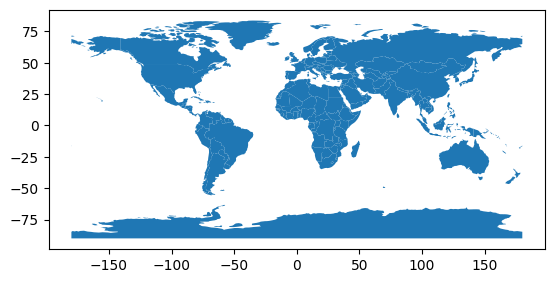

In [13]:
worldmap_df.plot();

Essayons avec un autre fichier :

In [14]:
wmpop_df = gpd.read_file(\
        'data/Natural-Earth-Data_110m_cultural/ne_110m_populated_places.shp')

In [6]:
wmpop_df.head()

SCALERANK  NATSCALE  LABELRANK           FEATURECLA          NAME NAMEPAR  \
0          8        10          3      Admin-0 capital  Vatican City    None   
1          7        20          0      Admin-0 capital    San Marino    None   
2          7        20          0      Admin-0 capital         Vaduz    None   
3          6        30          8  Admin-0 capital alt       Lobamba    None   
4          6        30          8      Admin-0 capital    Luxembourg    None   

  NAMEALT     NAMEASCII  ADM0CAP            CAPIN  ...  FCLASS_ID  FCLASS_PL  \
0    None  Vatican City        1             None  ...       None       None   
1    None    San Marino        1             None  ...       None       None   
2    None         Vaduz        1             None  ...       None       None   
3    None       Lobamba        0  Legislative and  ...       None       None   
4    None    Luxembourg        1             None  ...       None       None   

  FCLASS_GR FCLASS_IT FCLASS_NL FCLASS_SE FCLASS_BD FCLASS_UA FCLASS_TLC  \
0      None      None      None      None      None      None       None   
1      None      None      None      None      None      None       None   
2      None      None      None      None      None      None       None   
3      None      None      None      None      None      None       None   
4      None      None      None      None      None      None       None   

                    geometry  
0  POINT (12.45339 41.90328)  
1   POINT (12.44177 43.9361)  
2   POINT (9.51667 47.13372)  
3     POINT (31.2 -26.46667)  
4      POINT (6.13 49.61166)  

[5 rows x 138 columns]

Ce fichier contient semble-t-il des informations sur les capitales du monde :

In [16]:
for c in wmpop_df:
    print(c) # boucle pour afficher la totalité des colonnes

SCALERANK
NATSCALE
LABELRANK
FEATURECLA
NAME
NAMEPAR
NAMEALT
NAMEASCII
ADM0CAP
CAPIN
WORLDCITY
MEGACITY
SOV0NAME
SOV_A3
ADM0NAME
ADM0_A3
ADM1NAME
ISO_A2
NOTE
LATITUDE
LONGITUDE
POP_MAX
POP_MIN
POP_OTHER
RANK_MAX
RANK_MIN
MEGANAME
LS_NAME
MAX_POP10
MAX_POP20
MAX_POP50
MAX_POP300
MAX_POP310
MAX_NATSCA
MIN_AREAKM
MAX_AREAKM
MIN_AREAMI
MAX_AREAMI
MIN_PERKM
MAX_PERKM
MIN_PERMI
MAX_PERMI
MIN_BBXMIN
MAX_BBXMIN
MIN_BBXMAX
MAX_BBXMAX
MIN_BBYMIN
MAX_BBYMIN
MIN_BBYMAX
MAX_BBYMAX
MEAN_BBXC
MEAN_BBYC
TIMEZONE
UN_FID
POP1950
POP1955
POP1960
POP1965
POP1970
POP1975
POP1980
POP1985
POP1990
POP1995
POP2000
POP2005
POP2010
POP2015
POP2020
POP2025
POP2050
MIN_ZOOM
WIKIDATAID
WOF_ID
CAPALT
NAME_EN
NAME_DE
NAME_ES
NAME_FR
NAME_PT
NAME_RU
NAME_ZH
LABEL
NAME_AR
NAME_BN
NAME_EL
NAME_HI
NAME_HU
NAME_ID
NAME_IT
NAME_JA
NAME_KO
NAME_NL
NAME_PL
NAME_SV
NAME_TR
NAME_VI
NE_ID
NAME_FA
NAME_HE
NAME_UK
NAME_UR
NAME_ZHT
GEONAMESID
FCLASS_ISO
FCLASS_US
FCLASS_FR
FCLASS_RU
FCLASS_ES
FCLASS_CN
FCLASS_TW
FCLASS_IN
FCLASS_N

Affichons les géométries :

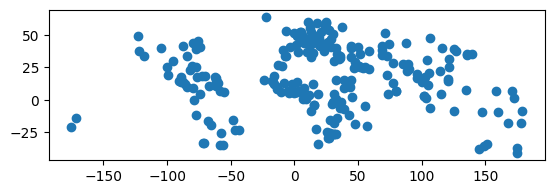

In [22]:
wmpop_df.plot();

On peut afficher des données (ici la colonne qui donne l’estimation de la population en 2025) :

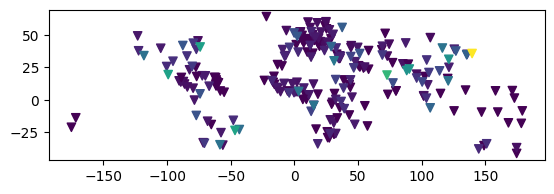

In [38]:
wmpop_df.plot('POP2025', marker='v');

Geopandas dispose d’une méthode `.explore()` qui ajoute un fond de carte et de l’interaction (si vous avez déjà matplotlib installé, installez aussi folium - que nous verrons plus en détail ci-dessous - et mapclassify) :

In [31]:
# !pip install matplotlib folium mapclassify

wmpop_df.explore()

Cette méthode repose sur Leaflet, une bibliothèque javascript. Il est possible que pour utiliser ̀`leaflet` Jupyter vous demande « Make this Notebook Trusted to load map:File -> Trust Notebook ». Dans Jupyter Lab, il faut faire 
`View` -> `Activate Command Palette`
et dans le champ de recherche taper `trust` vous pourrez choisir Trust Notebook, et confirmer.

On peut aussi superposer 2 tracés à l’aide de matplotlib : 

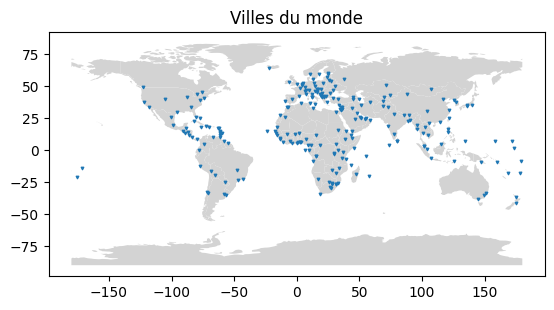

In [33]:
fig, ax = plt.subplots()

worldmap_df.plot(ax=ax, color='lightgray')
wmpop_df.plot(ax=ax, marker='v', markersize=3)

plt.title('Villes du monde')
plt.show()

Peut-on isoler une carte de l’Afrique ?
Regardons déjà la colonne « continent » :

In [40]:
worldmap_df.CONTINENT.unique()

array(['Oceania', 'Africa', 'North America', 'Asia', 'South America',
       'Europe', 'Seven seas (open ocean)', 'Antarctica'], dtype=object)

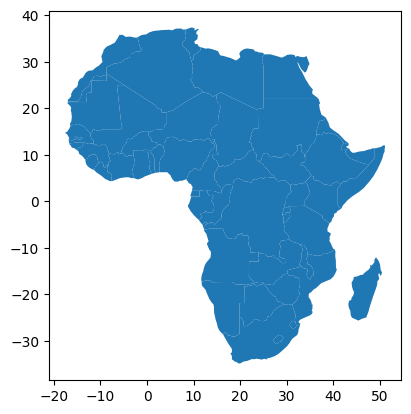

In [90]:
afriquemap_df = worldmap_df[worldmap_df['CONTINENT']=='Africa'].copy()
afriquemap_df.plot();

Calculons les coordonnées du centre de chaque pays :

In [42]:
afriquemap_df['CenterX'] = afriquemap_df['geometry'].map(lambda c: c.centroid.x)
afriquemap_df['CenterY'] = afriquemap_df['geometry'].map(lambda c: c.centroid.y)

Affichons maintenant la carte avec le code iso de chaque pays aux centres que nous venons de calculer :

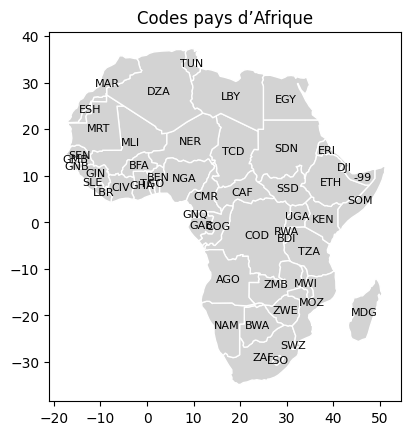

In [45]:
fig, ax = plt.subplots()
afriquemap_df.plot(ax=ax, color='lightgray', edgecolor='white')

for idx, row in afriquemap_df.iterrows():
    ax.text(row["CenterX"], 
            row["CenterY"],
            row["ISO_A3"], 
            ha="center", 
            va="center", 
            size=8)

plt.title('Codes pays d’Afrique')
plt.show()

Affichons la population estimée pour chaque pays, directement depuis la méthode `.plot()` du dataframe :

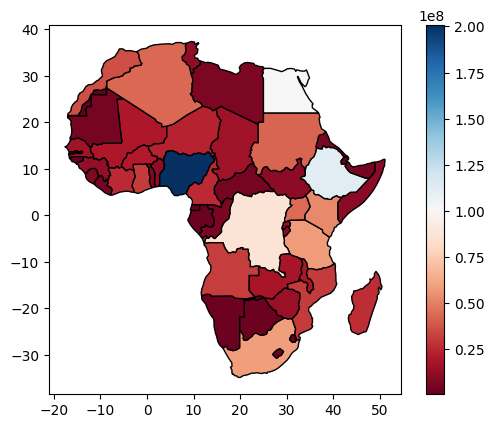

In [50]:
afriquemap_df.plot(column = "POP_EST",
                   cmap='RdBu',
                   legend=True,
                   edgecolor='black', 
                   label='Population estimate per state');

### Exercice

Reproduisez cet exemple dans d’autres régions du monde : explorez les données des fichiers utilisés.

In [89]:
# votre code ici



## Cartes chloroplèthes

Les cartes telles que nous avons produites, des « carte[s] thématique[s] où les régions sont colorées ou remplies d'un motif qui montre une mesure statistique » sont des cartes dites chloroplèthes (définition [Wikipédia](https://fr.wikipedia.org/wiki/Carte_choropl%C3%A8the)).

Ce sont des cartes très utilisées en dataviz, de nombreux outils permettent de les produire, avec plus ou moins d’interactivité : matplotlib (qu’on peut enrichir de surcouches come [cartopy](https://scitools.org.uk/cartopy/docs/latest/), etc.), [folium](https://python-visualization.github.io/folium/latest/) basée sur [Leaflet.js](https://leafletjs.com/), [plotly](https://plotly.com/python/), etc.

### Cartopy

C’est une surcouche de matplotlib qui peut être utiliser pour manipuler des projections, etc. Son module `feature` contient des données du projet Natural Earth, ce qui permet de les importer sans télécharger nous-même les fichiers du projet à chaque fois. En fait cartopy va les télécharger pour nous, il enverra un warning à chaque fois pour indiquer que quelque chose est téléchargé. On peut inhiber ces warnings avec `warnings.filterwarnings('ignore')` si vous le désirez.

#### Projections

Un exemple qui vous permet de comparer les différentes projections que nous avons évoqués dans la sections précédente, car Cartopy a été pensée pour être construite à l’aide de pyproj autour de ces système de projection (c’est avant tout un outil pédagogique). **ATTENTION** il y a une subtile différence par exemple avec un CRS comme WGS-84 qui n’est précisément pas un système de projection (PRS), mais un système de coordonnées (CRS).

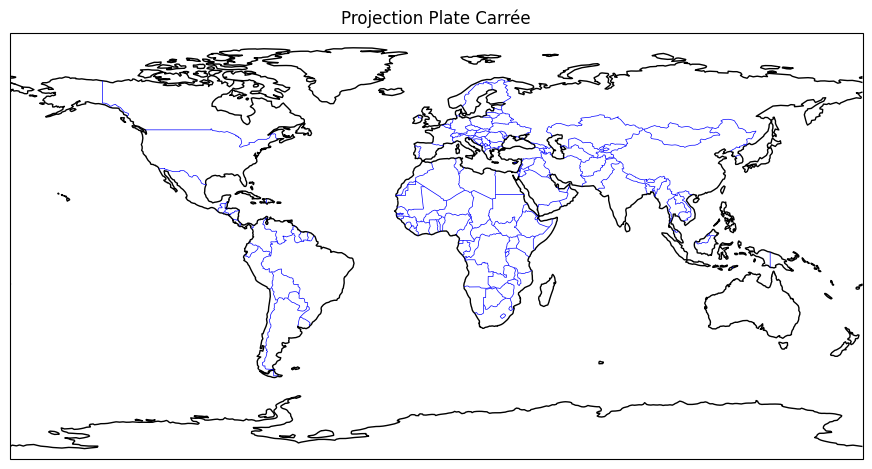

In [142]:
from cartopy import crs, feature

fig = plt.figure(figsize=(11, 8.5))
ax = plt.axes(projection=crs.PlateCarree(central_longitude=0))
ax.set_title("Projection Plate Carrée")
# Note : sur une projection plate carrée les points sont écartées du même nombre de degrés
ax.coastlines()
ax.add_feature(feature.BORDERS, linewidth=0.5, edgecolor='blue');

Montrons la même carte avec une autre projection, la projection de Mollweide ou *homolographique*, très utilisée pour les planisphères. C’est une projection pseudo-cylindrique qui conserve les aires (mais pas les angles)

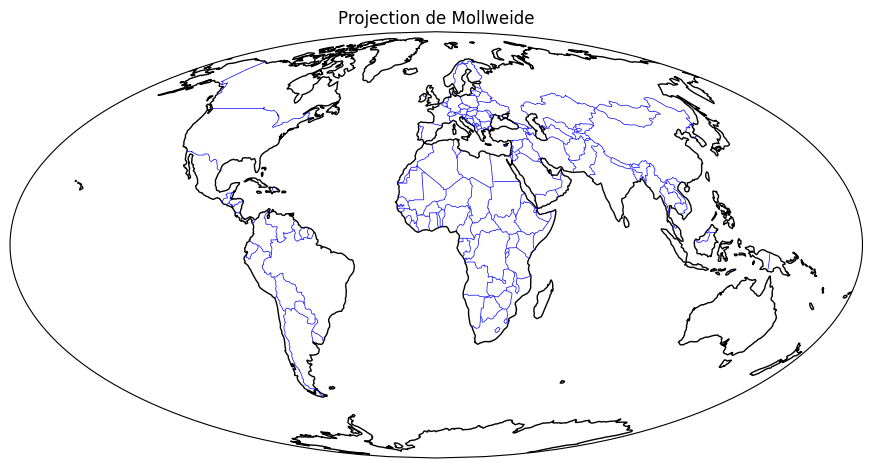

In [82]:
fig = plt.figure(figsize=(11, 8.5))
ax = plt.axes(projection=crs.Mollweide(central_longitude=0))
ax.set_title("Projection de Mollweide")
ax.coastlines()
ax.add_feature(feature.BORDERS, linewidth=0.5, edgecolor='blue');

On peut aussi ajouter une image de fond avec la méthode `ax.stock_img()`

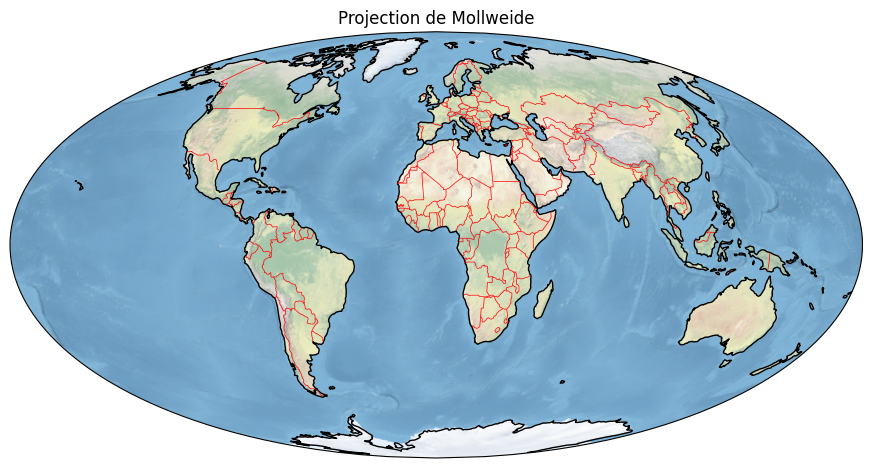

In [88]:
fig = plt.figure(figsize=(11, 8.5))
ax = plt.axes(projection=crs.Mollweide(central_longitude=0))
ax.set_title("Projection de Mollweide")
ax.coastlines()
ax.add_feature(feature.BORDERS, linewidth=0.5, edgecolor='red')
ax.stock_img();

On peut adopter des point de vue t

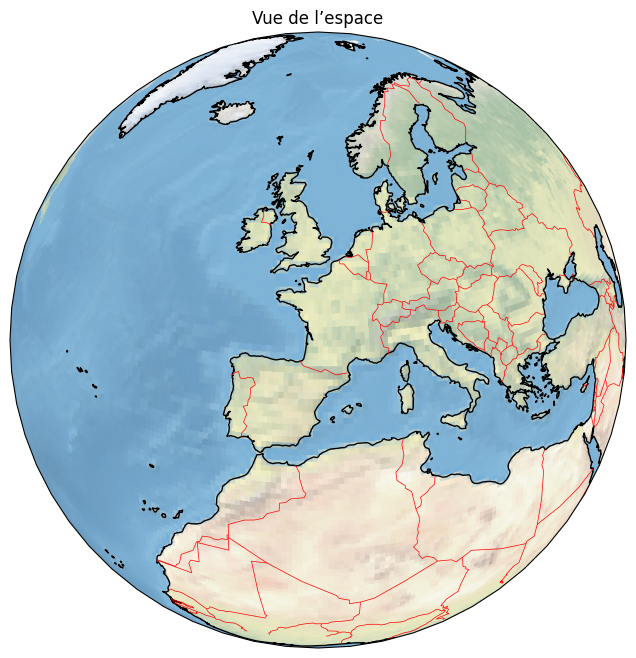

In [86]:
fig = plt.figure(figsize=(8,8))

projection=crs.NearsidePerspective(central_longitude=0,
                                    central_latitude=45,
                                    satellite_height=2500000)
ax = plt.axes(projection=projection)
ax.set_title("Vue de l’espace")
ax.coastlines(resolution='50m')
ax.add_feature(feature.BORDERS, linewidth=0.5, edgecolor='red')
ax.stock_img()
plt.show()

#### Zoom sur une région

On n’a pas toujours besoin d’afficher un panisphère au complet. Pour se focaliser sur une zone nous allons utiliser la méthode `.set_extent()`. Elle prend comme argument les coordonnées des 4 coins de la « fenêtre » qu’on va afficher, dans un CRS donné bien sûr. On peut très bien utiliser une projection différente pour définir `.set_extent()` et pour représenter les données géographiques.

Dans l’exemple suivant on va représenter les données géographiques avec une projection stéréographique (projection conforme – c.-à-d. qui conserve les angles – obtenue en projetant les points de la sphère terrestre sur un plan tangeant en un point défini). Et nous allons définir la « fenêtre » par des longitudes et latitudes limites en est et en ouest, dans une project plate carrée.

Nous allons : 
* d’abord définir ces limites (dans les 4 directions)
* déterminer le centre de la fenêtre où nous centrerons aussi la projection stéréographique
* définir une résolution pour les données Natural Earth
* déclarer notre figure
* utiliser la méthode `.gridlines` pour placer des repères (méridiens et parallèles)
* utiliser la méthode `.set_extent()` pour définir la « fenêtre »
* et rajouter différents `feature` que nous n’avons pas présentés, ainsi que la manière de les mettre en forme. Attention de fixer la résolution de ces features à égalité avec la résolution définie pour la figure, histoire que les coastlines correspondent (sinon ça « bave », testez pour voir !

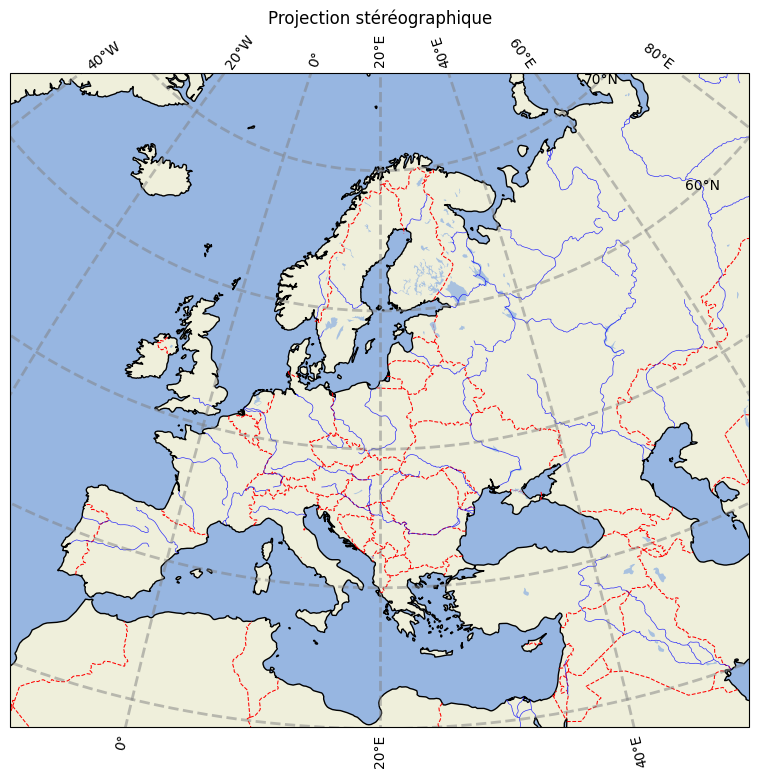

In [129]:
# définissons quelques constantes / paramètres :

projPC = crs.PlateCarree()
lonW = -10
lonE = 50
latS = 30
latN = 75
cLat = (latN + latS) / 2
cLon = (lonW + lonE) / 2
projStr = crs.Stereographic(central_longitude=cLon, central_latitude=cLat)
res = '50m'

# traçons notre figure avec ces paramètres :

fig = plt.figure(figsize=(11, 8.5))
ax = plt.axes(projection=projStr)
ax.set_title('Projection stéréographique')

gl = ax.gridlines(
    draw_labels=True, 
    linewidth=2, 
    color='gray', 
    alpha=0.5, 
    linestyle='--'
)

ax.set_extent([lonW, lonE, latS, latN], crs=projPC)

ax.coastlines(resolution=res, color='black')
ax.set_facecolor(feature.COLORS['water']) # on colore la mer
ax.add_feature(feature.LAND.with_scale(res)) # on colore la terre
ax.add_feature(feature.BORDERS.with_scale(res), 
                                linewidth=0.75, 
                                edgecolor='red', 
                                linestyle='--')
ax.add_feature(feature.LAKES.with_scale(res), alpha=0.8)
ax.add_feature(feature.RIVERS.with_scale(res), 
                                alpha=0.8, 
                                linewidth=0.5, 
                                edgecolor='blue')

#### Exercice

Explorez les différents paramètres vu ci-dessus pour bien comprendre leurs effets (notamment la résolution, utilisez des résolutions différntes, etc.).

In [126]:
# Votre code ici


#### Ajoutez des données

Notre objectif est d’ajouter des données sur les fonds de carte que nous avons créé. Nous allons pour cela la méthode `.add_geometries()` où les données que nous désirons affichées seront passé à l’arguement `array`. Le reste (notamment la barre de couleur pour la légende) est du matplotlib classique.

Mais il faut auparavant s’assurer que le `.crs` du geodataframe est bien dans un système de projection. Nous allons le redéfinir avec `crs.PlateCarree()`


In [137]:
afriquemap_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [178]:
afriquemap_df = afriquemap_df.to_crs(crs.PlateCarree())
afriquemap_df.crs

<Projected CRS: +proj=eqc +ellps=WGS84 +a=6378137.0 +lon_0=0.0 +to ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (unknown)
- N[north]: Northing (unknown)
- h[up]: Ellipsoidal height (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Equidistant Cylindrical
Datum: Unknown based on WGS 84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

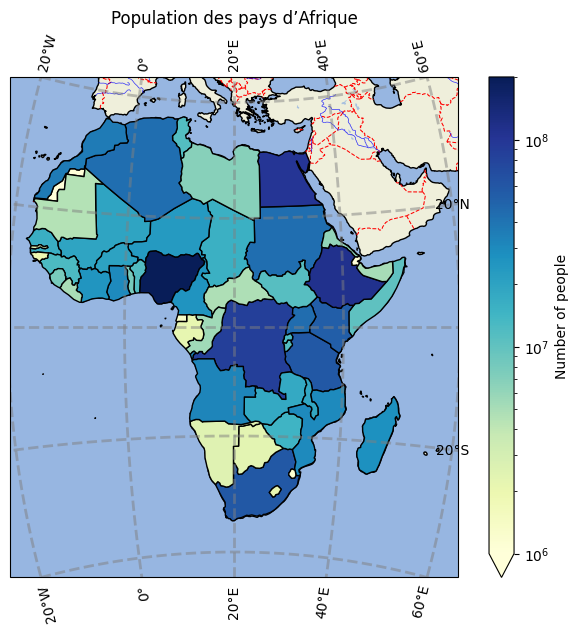

In [158]:
import matplotlib.colors as mcolors

projPC = crs.PlateCarree()
lonW = -20
lonE = 60
latS = -40
latN = 40
cLat = (latN + latS) / 2
cLon = (lonW + lonE) / 2
projStr = crs.Stereographic(central_longitude=cLon, central_latitude=cLat)
res = '50m'


fig = plt.figure(figsize=(8, 6.5))
ax = plt.axes(projection=projStr)
ax.set_title('Population des pays d’Afrique')

gl = ax.gridlines(
    draw_labels=True, 
    linewidth=2, 
    color='gray', 
    alpha=0.5, 
    linestyle='--'
)

ax.set_extent([lonW, lonE, latS, latN], crs=projPC)

ax.coastlines(resolution=res, color='black')
ax.set_facecolor(feature.COLORS['water']) # on colore la mer
ax.add_feature(feature.LAND.with_scale(res)) # on colore la terre
ax.add_feature(feature.BORDERS.with_scale(res), 
                                linewidth=0.75, 
                                edgecolor='red', 
                                linestyle='--')
ax.add_feature(feature.LAKES.with_scale(res), alpha=0.8)
ax.add_feature(feature.RIVERS.with_scale(res), 
                               alpha=0.8, 
                               linewidth=0.5, 
                               edgecolor='blue')

art = ax.add_geometries(afriquemap_df.geometry, 
                        crs=afriquemap_df.crs,
                        array=afriquemap_df.POP_EST,
                        edgecolor='black',
                        cmap='YlGnBu',
                        norm=mcolors.LogNorm(vmin=1e6))
cbar = fig.colorbar(art, orientation='vertical', extend='min')
cbar.set_label('Number of people')

Pour aller plus loin, et si vous rencontrez des problèmes d’import des données (format de fichier, etc.), n’hésitez pas à regarder la documentation de cartopy sur les entrées/sorties (modules cartopy.io, et notamment cartopy.io.shapereader).

### Folium

`pip install folium`

Folium est une bibliothèque qui peut apporter beaucoup d’interaction, basée sur la bibliothèque javascrip Leaflet (rappel : il inverse les lat/long en long/lat).

Folium permet très rapidement d’avoir un fond de carte, connecté avec un diffuseur de flux comme Open Street Map (mais aussi CartoDB, Stamen, Mapbox…): 

In [167]:
import folium

In [198]:
africa_map = folium.Map(location=[afriquemap_df.centroid.y.mean(), 
                                    afriquemap_df.centroid.x.mean()], 
                                    zoom_start=3, 
                                    tiles='openstreetmap')
africa_map

Cette carte de base, vide, peut se voir ajouter des éléments avec la méthode `.add_to()`.

Par exemple, on aurait très bien pu écrire (on en profite pour tester un autre diffuseur de fond de carte) :

In [199]:
africa_map = folium.Map(location=[afriquemap_df.centroid.y.mean(), 
                                    afriquemap_df.centroid.x.mean()], 
                                    zoom_start=3, 
                                    tiles=None)
folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(africa_map)
africa_map

Folium dispose par ailleurs d’une fonction `folium.Cloropleth()` pour créer très facilement des carte chloroplèthes. Cette fonction prend 3 arguments :
* `geo_data` : l’objet qui contient les géométries (a priori un fichier GeoJSON, mais on peut passer un geodataframe qui sera automatiquement converti en GeoJSON par Folium)
* `data` : le dataframe qui contient les données à afficher
* `columns` : les (2) colonnes qui vont servir à créer la chloroplèthe. Une colonne contient les entités géographiques (pays, régions, villes…) auxquelles se rapportent les mesures (métriques) que l’on doit représenter (la deuxième colonne)
* `key_on` : la clé par laquelle géométrie et entités vont être mises en correspondance pour créer la carte

On voit que cette fonction n’a pas été prévue dans le cas où on a un seul geodataframe qui contient toutes les données (géométries, entitée et données à afficher). En fait le problème vient du paramètre `key_on` qui hérite de contraintes du Leaflet (javascript), il  va falloir l’écrire sur ce format : `feature.properties.<nom_de_la_colonne_des_entités>`, ici cela deonnera donc `feature.properties.ISO_A3` :


In [200]:
scale = (afriquemap_df['POP_EST'].quantile((0,0.1,0.75,0.9,0.98,1))).tolist()
folium.Choropleth(geo_data=afriquemap_df,
                 name='Population par pays en Afrique',
                 data=afriquemap_df,
                 columns=['ISO_A3','POP_EST'],
                 key_on="feature.properties.ISO_A3",
                 threshold_scale=scale,
                 fill_color='YlGnBu',
                 fill_opacity=1,
                 line_opacity=0.2,
                 legend_name='Population',
                 smooth_factor=0
                ).add_to(africa_map)

africa_map

L’intérêt de folium est qu’il pousse l’interactivité jusqu’à pouvoir ajouter des éléments lorsque l’on survole la carte, ajouter un panneau de contrôle…

#### Information en survolant la carte

Une possibilité três intéressante lorsque l’on rajoute de l’interactivité à une dataviz est de pouvoir disposer d’infobulles qui donnent les valeurs précises des métriques dont on dispose quand on survole un élément ou objet. Ici on a une représentation en couleur de la population de chaque pays, en survolant les pays on aimerait bien disposer d’information plus détaillées, au moins l’indentifiant du pays et la valeur exacte de sa population.

On peut rajouter un tel objet (attention à la syntaxe avec des bouts de javascript/HTML/CSS dedans)

In [201]:
folium.features.GeoJson(
                    data=afriquemap_df,
                    name='Population / contry',
                    smooth_factor=2,
                    style_function=lambda x: {'color':'black','fillColor':'transparent','weight':0.5},
                    tooltip=folium.features.GeoJsonTooltip(
                        fields=['ISO_A3',
                                'POP_EST'
                               ],
                        aliases=["Code pays:",
                                 "Population estimée:"
                                ], 
                        localize=True,
                        sticky=False,
                        labels=True,
                        style="""
                            background-color: #F0EFEF;
                            border: 2px solid black;
                            border-radius: 3px;
                            box-shadow: 3px;
                        """,
                        max_width=800,),
                            highlight_function=lambda x: {'weight':3,'fillColor':'grey'},
                        ).add_to(africa_map) 

africa_map

Exercice : rajouter des champs aux infobulles comme le nom complet du pays, ou d’autres éléments du dataframe qui vous semblent pertinents. Jouez avec les paramètres et liser la doc pour comprendre à quoi ils servent.

In [195]:
# votre code ici


Folium nous permet aussi de rajouter des panneaux de contrôle, etc. mais cela dépasse le cadre de ce cours.

Enfin on peut aussi sauvegarder notre carte au format html : 

In [202]:
africa_map.save("africa_pop.html") 

### Plotly

Plotly permet aussi de créer des cartes chloroplèthes très simplement.
Voir le tutoriel directement dans la doc : https://plotly.com/python/choropleth-maps/

## Exercice

Plus compliqué : aggrégeons des données de sources différentes ! Essayez dans votre projet si elles se prêtent à la cartographie, sinon cherchez ces données dans les sources indiquées.

1. Trouver des données chiffrées avec info geographique (pays, villes…). Attention, ne pas prendre des données déjà agrégées par pays, régions, etc. c’est le but de l’exercice ;)
2. Merger/groupby ces données pour calculer des scores (moyennes, décompte, pourcentage, ce que vous voulez !) par entitées géographiques, par exemple pays, régions, arrondissements, en fonction de la carte dont vous disposez (il faudra sûrement recoder / renommer des colonnes de réf. pays/région, etc pour pouvoir merger sur un df geospatial)
3. Afficher une carte qui associe un code couleur à chaque valeur du score (palette, « température »)